**Import Library**

In [1]:
import re
import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from underthesea import word_tokenize
from collections import Counter
import fasttext


#from google.colab import drive
#drive.mount('/content/gdrive')


#path = "/content/gdrive/MyDrive/KLTN/"


**Read data & Visualize**

In [2]:
dt = pd.read_csv("data/vbpl.csv", encoding="utf-8")
dt.head()

,Thực thể tham chiếu,Quan hệ,Nội dung Trước thực thể được tham chiếu,Thực thể được tham chiếu,Nội dung Sau thực thể được tham chiếu
0,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC,NaN,Luật tổ_chức Chính_phủ ngày 30 tháng 9 năm 1992,
1,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC,NaN,Bộ_Luật Lao_động ngày 23 tháng 6 năm 1994,
2,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC,NaN,"Pháp_lệnh Cán_bộ , công_chức ngày 26/02 năm 1...",
3,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC,"Những người được quy_định tại các khoản 2 , 3...","Pháp_lệnh Cán_bộ , công_chức",
4,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC,"Cán_bộ , công_chức làm_việc ở những ngành_ngh...","Pháp_lệnh Cán_bộ , công_chức",


In [5]:
A = "Thực thể tham chiếu"
Label = "Quan hệ"
B = "Thực thể được tham chiếu"
Before_B = "Nội dung Trước thực thể được tham chiếu"
After_B = "Nội dung Sau thực thể được tham chiếu"

data_Clean = dt[[A,Label,Before_B,B,After_B]].copy()
data_Clean[Label] = dt[Label].fillna('None')
data_Clean[[A, B]].dropna()
data_Clean.info()


data_Clean['Quan hệ'].unique()
data_Clean.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45313 entries, 0 to 45312
Data columns (total 5 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Thực thể tham chiếu                      45313 non-null  object
 1   Quan hệ                                  45313 non-null  object
 2   Nội dung Trước thực thể được tham chiếu  29417 non-null  object
 3   Thực thể được tham chiếu                 45313 non-null  object
 4   Nội dung Sau thực thể được tham chiếu    45313 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


,Thực thể tham chiếu,Quan hệ,Nội dung Trước thực thể được tham chiếu,Thực thể được tham chiếu,Nội dung Sau thực thể được tham chiếu
0,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC,NaN,Luật tổ_chức Chính_phủ ngày 30 tháng 9 năm 1992,
1,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC,NaN,Bộ_Luật Lao_động ngày 23 tháng 6 năm 1994,
2,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC,NaN,"Pháp_lệnh Cán_bộ , công_chức ngày 26/02 năm 1...",
3,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC,"Những người được quy_định tại các khoản 2 , 3...","Pháp_lệnh Cán_bộ , công_chức",
4,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC,"Cán_bộ , công_chức làm_việc ở những ngành_ngh...","Pháp_lệnh Cán_bộ , công_chức",
5,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC,"Cán_bộ , công_chức thôi_việc mà không đủ điều...",Bộ_Luật Lao_động,thì được hưởng trợ_cấp một lần và các quyền_l...
6,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC,"Thời_gian cán_bộ , công_chức nghỉ theo quy_đị...",Bộ_Luật Lao_động,
7,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC,"Thời_gian cán_bộ , công_chức nghỉ sinh con th...",Bộ_Luật Lao_động,
8,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC,"Thời_gian cán_bộ , công_chức bị xử_lý kỷ_luật...","Pháp_lệnh Cán_bộ , công_chức",
9,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC,"Thời_gian cán_bộ , công_chức bị tạm đình_chỉ ...","Pháp_lệnh Cán_bộ , công_chức",


In [6]:
groups = data_Clean.groupby(by=Label).count()[A]
fig = go.Figure()
fig.add_trace(go.Bar(
    x=groups.index,
    y=groups,
    marker_color='cadetblue',
    width=[0.4, 0.4]))
fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

**Preprocessing**

In [7]:
def load_dicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# Chuyển đổi mã kí tự 1252 sang UTF-8
def covert_unicode(text):
    dicchar = load_dicchar()
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], text)

def text_preprocessing(document):
    # Chuyển đổi mã kí tự 1252 sang UTF-8
    document['Text'] = document['Text'].apply(covert_unicode)
    # Đưa về dạng chữ thường
    document['Text'] = document['Text'].str.lower()
    # xóa các ký tự không cần thiết
    document['Text'] = document['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
    document = document['Text'].apply(lambda y: re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',str(y)))
    return document

In [8]:
dt_clean =  data_Clean.loc[data_Clean[Label].isin(groups.index)].reset_index(drop=True)
dt_clean.info()
dt_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45313 entries, 0 to 45312
Data columns (total 5 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Thực thể tham chiếu                      45313 non-null  object
 1   Quan hệ                                  45313 non-null  object
 2   Nội dung Trước thực thể được tham chiếu  29417 non-null  object
 3   Thực thể được tham chiếu                 45313 non-null  object
 4   Nội dung Sau thực thể được tham chiếu    45313 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


,Thực thể tham chiếu,Quan hệ,Nội dung Trước thực thể được tham chiếu,Thực thể được tham chiếu,Nội dung Sau thực thể được tham chiếu
0,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC,NaN,Luật tổ_chức Chính_phủ ngày 30 tháng 9 năm 1992,
1,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC,NaN,Bộ_Luật Lao_động ngày 23 tháng 6 năm 1994,
2,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC,NaN,"Pháp_lệnh Cán_bộ , công_chức ngày 26/02 năm 1...",
3,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC,"Những người được quy_định tại các khoản 2 , 3...","Pháp_lệnh Cán_bộ , công_chức",
4,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC,"Cán_bộ , công_chức làm_việc ở những ngành_ngh...","Pháp_lệnh Cán_bộ , công_chức",


In [9]:

dt_clean['Text'] = dt_clean.apply(lambda d: f'{d[A]} {d[After_B]} {d[B]} {d[Before_B]}'.strip(), axis=1)

dt_clean.head()

,Thực thể tham chiếu,Quan hệ,Nội dung Trước thực thể được tham chiếu,Thực thể được tham chiếu,Nội dung Sau thực thể được tham chiếu,Text
0,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC,NaN,Luật tổ_chức Chính_phủ ngày 30 tháng 9 năm 1992,,"Nghị định Về chế độ thôi việc đối với cán bộ, ..."
1,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC,NaN,Bộ_Luật Lao_động ngày 23 tháng 6 năm 1994,,"Nghị định Về chế độ thôi việc đối với cán bộ, ..."
2,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC,NaN,"Pháp_lệnh Cán_bộ , công_chức ngày 26/02 năm 1...",,"Nghị định Về chế độ thôi việc đối với cán bộ, ..."
3,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC,"Những người được quy_định tại các khoản 2 , 3...","Pháp_lệnh Cán_bộ , công_chức",,"Nghị định Về chế độ thôi việc đối với cán bộ, ..."
4,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC,"Cán_bộ , công_chức làm_việc ở những ngành_ngh...","Pháp_lệnh Cán_bộ , công_chức",,"Nghị định Về chế độ thôi việc đối với cán bộ, ..."


In [10]:
dt_preprocess =  dt_clean[['Text', 'Quan hệ']].copy()
dt_preprocess.head()


,Text,Quan hệ
0,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC
1,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC
2,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",CC
3,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC
4,"Nghị định Về chế độ thôi việc đối với cán bộ, ...",DC


In [11]:
dt_preprocess['Text'] = text_preprocessing(dt_preprocess)
dt_preprocess.head()

,Text,Quan hệ
0,nghị định về chế độ thôi việc đối với cán bộ c...,CC
1,nghị định về chế độ thôi việc đối với cán bộ c...,CC
2,nghị định về chế độ thôi việc đối với cán bộ c...,CC
3,nghị định về chế độ thôi việc đối với cán bộ c...,DC
4,nghị định về chế độ thôi việc đối với cán bộ c...,DC


**Text Length**

In [10]:
def check_length(data):
    min_length = float('inf')
    max_length = 0
    total_length = 0
    count = 0
    length_counts = {}

    for text in data:
        length = len(text)

        # Update minimum length
        if length < min_length:
            min_length = length
            m = count

        # Update maximum length
        if length > max_length:
            max_length = length

        # Update total length for average calculation
        total_length += length

        # Update length counts for mode calculation
        if length in length_counts:
            length_counts[length] += 1
        else:
            length_counts[length] = 1

        count += 1

    average_length = round(total_length / count)
    mode_length = max(length_counts, key=length_counts.get)

    count_mode = 0
    for i in data:
        if len(i) == mode_length:
            count_mode = count_mode + 1
    count_avg = 0
    for j in data:
        if len(j) == average_length:
            count_avg = count_avg + 1


    print("Minimum length:", min_length)
    print("Maximum length:", max_length)
    print("Average length:", average_length)
    print("Mode length:", mode_length)
    print("Count Mode length:", count_mode)
    print("Count Avg length:", count_avg)


check_length(dt_preprocess['Text'])

Minimum length: 45
Maximum length: 1447
Average length: 306
Mode length: 238
Count Mode length: 214
Count Avg length: 109


In [11]:
max_length = 250  # Chiều dài tối đa của câu lấy theo độ dài trung bình của toàn bộ tập dữ liệu


**Tokenization**

In [12]:
def tokenization(data):
    Text_col = data
    tokenizer = Tokenizer(split=' ')
    tokenizer.fit_on_texts(Text_col)
    words_to_index = tokenizer.word_index
    vocab_size = len(words_to_index) + 1

    # chuyển đổi dữ liệu văn bản thành các chuỗi số
    tokenizer_seq = tokenizer.texts_to_sequences(Text_col)

    # Đảm bảo mỗi sequece có cùng độ dài
    # 'post' có nghĩa là thêm padding vào cuối mỗi sequence
    # 'pre' có nghĩa là thêm padding vào đầu mỗi sequence
    tokenizer_pad = pad_sequences(tokenizer_seq, padding='pre', truncating='post', maxlen=max_length)

    return tokenizer_pad, vocab_size, words_to_index

In [13]:
# Tách từ
data_tokenizer = dt_preprocess.copy()
data_tokenizer['Text'] = data_tokenizer['Text'].apply(word_tokenize)

data_tokenizer.info()
data_tokenizer.head()


data_tokenizer_pad, vocab_size, words_to_index = tokenization(data_tokenizer['Text'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45313 entries, 0 to 45312
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     45313 non-null  object
 1   Quan hệ  45313 non-null  object
dtypes: object(2)
memory usage: 708.1+ KB


In [14]:
print(data_tokenizer_pad)

[[   0    0    0 ...    9  797   20]
 [   0    0    0 ...    9  987   20]
 [   0    0    0 ...    9  779   20]
 ...
 [   0    0    0 ... 1278   90   12]
 [   0    0    0 ...    7 1055    1]
 [   0    0    0 ...    3  535  197]]


**Embedding**

In [ ]:
with open('model/fasttext/vbpl_text.txt', 'w', encoding="utf-8") as file:
    # Write content to the
    for i in dt_preprocess['Text']:
        file.write(i+"\n")

In [ ]:
model_fasttext = fasttext.train_unsupervised('model/fasttext/vbpl_text.txt', maxn=0, dim=100)
model_fasttext.save_model('model/fasttext/fasttext_100d_vbpl.bin')

In [ ]:
all_text = ' '.join(dt_preprocess['Text'])

# Split the text into individual words
words = all_text.split()

# Count the frequency of each word
word_counts = Counter(words)

# Find the word with the highest frequency
most_common_word, frequency = word_counts.most_common(1)[0]

print("Most common word:", most_common_word)
print("Frequency:", frequency)

Most common word: của
Frequency: 193472


In [15]:
embedding_dim = 100  # Kích thước nhúng


ft = fasttext.load_model('model/fasttext/fasttext_100d_vbpl.bin')
embed_vector_size = ft.get_word_vector('của').shape[0]

embed_vector_matrix = np.zeros((vocab_size, embed_vector_size))

for word, i in words_to_index.items():
    embedding_vector = ft.get_word_vector(word)
    if any(embedding_vector):
        embed_vector_matrix[i] = embedding_vector
    else:
        embed_vector_matrix[i] = np.random.uniform(low=-1, high=1, size= embed_vector_size)

print(f"Max length | input_length      = {max_length}")
print(f"input_dim  | vocab_size        = {vocab_size}")
print(f"output_dim | embed_vector_size = {embed_vector_size}")
print(f"weights = {embed_vector_matrix.shape}")

embedding = Embedding(input_dim=vocab_size, output_dim=embed_vector_size,
                      input_length=max_length, weights=[embed_vector_matrix], trainable=False)

Max length | input_length      = 250
input_dim  | vocab_size        = 20114
output_dim | embed_vector_size = 100
weights = (20114, 100)



**Create Model**

In [16]:
classes = data_tokenizer['Quan hệ'].nunique()
print(f"Number labels = {classes}")

def create_model():
    lstm_units = 256  # Số đơn vị LSTM
    dropout_val = 0.2
    recurrent_dropout = 0.1

    model = Sequential()
    model.add(embedding)
    model.add(LSTM(lstm_units, return_sequences=True, dropout=dropout_val,recurrent_dropout=recurrent_dropout))
    model.add(LSTM(lstm_units, return_sequences=True, dropout=dropout_val,recurrent_dropout=recurrent_dropout))
    model.add(LSTM(lstm_units, return_sequences=True, dropout=dropout_val,recurrent_dropout=recurrent_dropout))
    model.add(SeqSelfAttention())
    model.add(Flatten())
    model.add(Dense(classes, activation="softmax"))

    # Model compiling
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

Number labels = 7


In [17]:
# Chia dataset thành tập training thành train_val và test
X = data_tokenizer_pad
y = data_tokenizer['Quan hệ']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y.values, test_size=0.2, random_state=40)

In [18]:
# encode label
label_encoder = LabelEncoder()
label_encoder.fit(data_tokenizer["Quan hệ"].values)
print('\nLabels:',list(label_encoder.classes_), '\n')
y_train_val = label_encoder.transform(y_train_val)
y_test = label_encoder.transform(y_test)

# Chia train_val thành train và validation
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=40)

print("Size Train: ",X_train.shape, y_train.shape)
print("Size Test: ",X_test.shape, y_test.shape)
print("Size Validation: ",X_val.shape, y_val.shape)


Labels: ['BTT', 'CC', 'DHD', 'DSD', 'DaC', 'HHL', 'none'] 

Size Train:  (27187, 250) (27187,)
Size Test:  (9063, 250) (9063,)
Size Validation:  (9063, 250) (9063,)


**Run**

In [19]:
model = create_model()
batchSize = 128
epoch = 20
#print(batchSize)
model.summary()


c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning:

The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          2011400   
                                                                 
 lstm (LSTM)                 (None, 250, 256)          365568    
                                                                 
 lstm_1 (LSTM)               (None, 250, 256)          525312    
                                                                 
 lstm_2 (LSTM)               (None, 250, 256)          525312    
                                                                 
 seq_self_attention (SeqSel  (None, 250, 256)          16449     
 fAttention)                                                     
                                                                 
 flatten (Flatten)           (None, 64000)             0         
                                                       

In [20]:
# Ghi lại thời điểm bắt đầu
start_time = time.time()
checkpoint_path = "".join(['checkpoint','vbpl_ft',"/cp.ckpt"])
checkpoint_dir = os.path.dirname(checkpoint_path)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
checkpointing = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
lstm_model_history = model.fit(X_train, y_train, batch_size=batchSize, epochs=epoch, callbacks=[earlystopping,checkpointing], validation_data=(X_val, y_val))

# Tính thời gian đã trôi qua
training_time = round(time.time() - start_time, 2)

Epoch 1/20


213/213 [==============================] - ETA: 0s - loss: 0.6369 - accuracy: 0.8091 
Epoch 1: saving model to checkpointvbpl_ft\cp.ckpt
213/213 [==============================] - 7214s 34s/step - loss: 0.6369 - accuracy: 0.8091 - val_loss: 0.5263 - val_accuracy: 0.8578
Epoch 2/20
213/213 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.8732 
Epoch 2: saving model to checkpointvbpl_ft\cp.ckpt
213/213 [==============================] - 9369s 44s/step - loss: 0.4264 - accuracy: 0.8732 - val_loss: 0.4027 - val_accuracy: 0.8739
Epoch 3/20
213/213 [==============================] - ETA: 0s - loss: 0.3704 - accuracy: 0.8880 
Epoch 3: saving model to checkpointvbpl_ft\cp.ckpt
213/213 [==============================] - 10427s 49s/step - loss: 0.3704 - accuracy: 0.8880 - val_loss: 0.3965 - val_accuracy: 0.8785
Epoch 4/20
213/213 [==============================] - ETA: 0s - loss: 0.3421 - accuracy: 0.8955 
Epoch 4: saving model to checkpointvbpl_ft\cp.ckpt
213

**Save Model**

In [21]:
# thu tu cac chi so: maxLength_Batch_epochs_dropout_recurrentDropout
path = f"model/model_classify_law_rel_vbpl_256lstm_{max_length}_{batchSize}_{epoch}_{0.2}_{0.1}_{training_time}.h5"

print(path)
model.save(path)

model/model_classify_law_rel_vbpl_256lstm_250_128_20_0.2_0.1_117045.19.h5


c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



**Prediction**

In [22]:
# Predictions on the Test Set
score = model.evaluate(X_test, y_test)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

284/284 [==============================] - 175s 615ms/step - loss: 0.2761 - accuracy: 0.9192
Test Score: 0.27613332867622375
Test Accuracy: 0.9192320704460144


In [23]:
start = None
end = None

# Phân loại 
y_pred = model.predict(X_test[start:end])
# Mã hóa label
y_pred_original = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_test_original = label_encoder.inverse_transform(y_test[start:end])

# In ra kết quả phân loại
print(f"Kết quả thực tế: {y_test_original}")
print(f"Kết quả mô hình phân loại: {y_pred_original} - {y_pred_original == y_test_original}")

284/284 [==============================] - 161s 565ms/step
Kết quả thực tế: ['DaC' 'DaC' 'CC' ... 'DaC' 'CC' 'DaC']
Kết quả mô hình phân loại: ['DaC' 'DaC' 'CC' ... 'DaC' 'CC' 'BTT'] - [ True  True  True ...  True  True False]


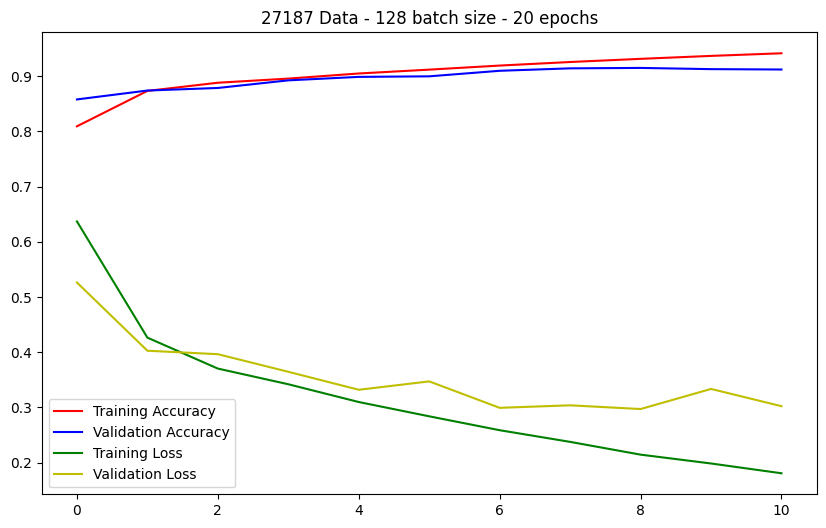

In [24]:
def plot_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(10,6))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.plot(epochs, loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')

    plt.title(f'{X_train.shape[0]} Data - {batchSize} batch size - {epoch} epochs')
    plt.legend(loc=0)
    plt.savefig(f'images/vbpl_img_256lstm_{max_length}_{batchSize}_{epoch}_0.2_0.1_{X_train.shape[0]}_{training_time}.png')
    plt.show()


plot_graph(lstm_model_history)

In [25]:
# Calculate precision, recall, and F1 score for each class
precision_per_class = precision_score(y_test_original, y_pred_original, average=None)
recall_per_class = recall_score(y_test_original, y_pred_original, average=None)
f1_per_class = f1_score(y_test_original, y_pred_original, average=None)

# Calculate macro-average precision, recall, and F1 score
macro_precision = round(np.mean(precision_per_class),3)
macro_recall = round(np.mean(recall_per_class),3)
macro_f1 = round(np.mean(f1_per_class),3)

# Create a DataFrame for the table
metrics_table_per_class = pd.DataFrame({
    'Class': np.unique(y_test_original),
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1 Score': f1_per_class
})

# Print the table per class
print("Metrics Table per Class:")
print(metrics_table_per_class)

# Print macro-average metrics
print("\nMacro-Average Metrics:")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1 Score: {macro_f1}")

Metrics Table per Class:
  Class  Precision    Recall  F1 Score
0   BTT   0.832700  0.752577  0.790614
1    CC   0.950690  0.969760  0.960130
2   DHD   0.500000  0.320000  0.390244
3   DSD   0.895349  0.733333  0.806283
4   DaC   0.918043  0.966724  0.941755
5   HHL   0.816092  0.710000  0.759358
6  none   0.587156  0.200627  0.299065

Macro-Average Metrics:
Macro Precision: 0.786
Macro Recall: 0.665
Macro F1 Score: 0.707


**Confusion Matrix**

In [26]:
# Tìm tất cả các nhãn duy nhất
labels = np.unique(np.concatenate((y_test_original, y_pred_original)))

# Tạo ma trận confusion
confusion = confusion_matrix(y_test_original, y_pred_original, labels=labels)

print("Ma trận confusion:")
print(confusion)

Ma trận confusion:
[[ 219   15    1    1   33   12   10]
 [  11 3239    2    0   80    2    6]
 [   0    8   16    1   25    0    0]
 [   2    5    0   77   15    5    1]
 [   6  100   13    4 4503   12   20]
 [   9   12    0    0   58  213    8]
 [  16   28    0    3  191   17   64]]
